2024新的

In [1]:
!pip install torchviz

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------------------------- ------------- 30.7/47.1 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 585.5 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4139 sha256=67b8fda9499b7962d9b8a10cd7ae513b548f74f64e9d798b079b7fc3e1aff7b1
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\98\f2\3d\290537e0ff7f67aaa647847a10fb5ee5eca305b3c41a774523
Successfully built torchviz


In [2]:
!pip install tsai

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/324.3 kB ? eta -:--:--
   ------- -------------------------------- 61.4/324.3 kB 3.2 MB/s eta 0:00:01
   ----------------- ---------------------- 143.4/324.3 kB 1.7 MB/s eta 0:00:01
   ----------------------------------- ---- 286.7/324.3 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 324.3/324.3 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/234.5 kB ? eta -:--:--
   --------------------------------------- 234.5/234.5 kB 14.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.5 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.5 MB 12.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.8/2.5 MB 14.3 MB/s eta 0:00:01
   ----------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchviz import make_dot

from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize

from tsai.all import *
from tsai.models.GatedTabTransformer import GatedTabTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('mobilegt-unifeaturedata-oversampler-30w-extendf.csv')
data = data.rename(columns={'35':'label'})
x=data.iloc[:,:-1].copy()
x.drop(x.columns[0], axis=1, inplace=True)
y=data.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,stratify=y,random_state=40,test_size=0.3)
y_test = list(y_test)

In [3]:
data['label'] = data['label'].astype(str)
dls=TabularDataLoaders.from_df(data, path=".", y_names="label",
    cat_names = ['0', '1','2','3','4','5','6','7','8','9',
                 '10','11','12','13','14','15','16','17','18',
                 '19','20','21','22','23','24',
                 '25','26','27','28','29','30',
                 '31','32','33','34'],
    procs = [Categorify, FillMissing, Normalize])
my_array = np.array(y_train)
x_categ = torch.tensor(my_array)
x_categ = x_categ.view(1,len(y_train))
x_categ = x_categ.int()
x_categ.size(),x_categ

(torch.Size([1, 214300]),
 tensor([[7, 5, 3,  ..., 9, 3, 4]], dtype=torch.int32))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.170965,0.191340,0.965196,0.965237,0.965335,0.965229,15:41
1,0.124140,0.186327,0.965032,0.965082,0.965188,0.965081,15:06
2,0.070588,0.217592,0.957307,0.957284,0.958333,0.957476,16:11
3,0.050077,0.217166,0.959610,0.959663,0.960474,0.959865,15:08
4,0.027971,0.216005,0.961145,0.961220,0.961395,0.961268,15:02
5,0.020642,0.240319,0.948324,0.948448,0.948830,0.948473,15:17
6,0.012273,0.302358,0.934768,0.934907,0.939304,0.934592,15:02
7,0.005859,0.313790,0.934344,0.934115,0.938927,0.934456,15:02
8,0.002576,0.367760,0.928317,0.928589,0.937912,0.929146,15:05
9,0.002116,0.304275,0.940011,0.940207,0.941408,0.939688,15:07


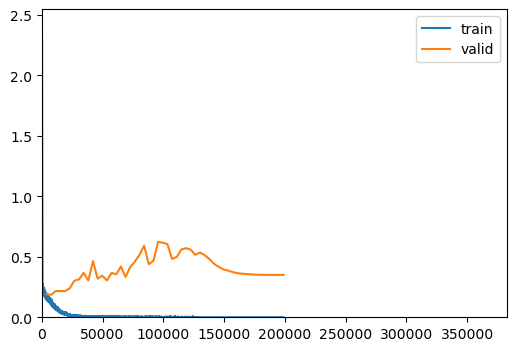

KeyboardInterrupt: 

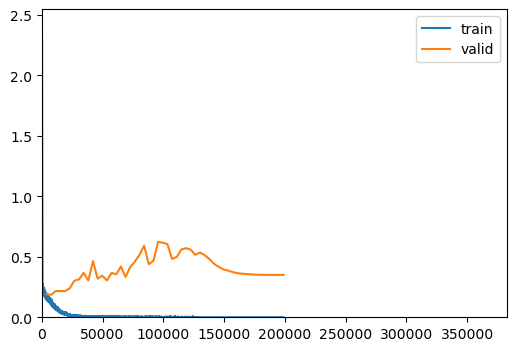

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from fastai.callback.all import *
from sklearn.metrics import precision_score, recall_score, f1_score
from fastai.metrics import *
from sklearn.metrics import precision_score, f1_score
def PrecisionMacro(*args, **kwargs):
    return AccumMetric(precision_score, dim_argmax=-1, average='macro', *args, **kwargs)

def RecallMacro(*args, **kwargs):
    return AccumMetric(recall_score, dim_argmax=-1, average='macro', *args, **kwargs)

def F1ScoreMacro(*args, **kwargs):
    return AccumMetric(f1_score, dim_argmax=-1, average='macro', *args, **kwargs)

model = GatedTabTransformer(dls.classes,dls.cont_names,dls.c,mlp_d_model=32,mlp_d_ffn=64,mlp_layers=4)
learn = Learner(dls,model,cbs=ShowGraphCallback(),loss_func=CrossEntropyLossFlat(),metrics=[accuracy, PrecisionMacro(), RecallMacro(), F1ScoreMacro()])
# 训练模型
learn.fit_one_cycle(100, 1e-3)


In [9]:
from fastai.vision.all import *
import torchvision.models as models
from tsai.all import *
from fastai.learner import Learner
from fastai.metrics import accuracy, F1Score, Precision, Recall

mobilenetv3 = models.mobilenet_v3_large(pretrained=True)  # 根据需要选择预训练或自定义版本
mobilenetv3.classifier[3] = nn.Linear(in_features=mobilenetv3.classifier[3].in_features, out_features=dls.c)  # 调整最后一层以匹配你的分类任务

# 使用tsai的Learner
learn = Learner(dls,
                mobilenetv3,
                metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')],
                cbs=ShowGraphCallback(),
                loss_func=CrossEntropyLossFlat())

# 训练模型
#learn.fit_one_cycle(100, 1e-3)
